# import imprortant library


In [14]:
import numpy as np
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from keras.utils import to_categorical
import torch
import warnings
warnings.filterwarnings('ignore')
import torchvision.models as models
from keras.utils import to_categorical
from sklearn.model_selection import KFold 
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch import optim , autocast
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torchvision import transforms, datasets
from collections import Counter
from torch.optim import AdamW
from sklearn.metrics import confusion_matrix
from torchvision.models import googlenet
from efficientnet_pytorch import EfficientNet
import torch.utils.data as data
%pylab inline
import torch.cuda as cuda
import time
import psutil

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# load dataset


In [2]:
wafer_tensors = torch.load('wafer_tensors.pt')
label_wm = torch.load('label_wm.pt')

In [3]:
print("Wafer Tensors Shape:", wafer_tensors.shape)
print("Label Tensors Shape:", label_wm.shape)

Wafer Tensors Shape: torch.Size([368568, 3, 56, 56])
Label Tensors Shape: torch.Size([368568, 1, 36])


In [4]:
label = []
label_wm[0].squeeze()
classes = ['C+EL', 'C+EL+L', 'C+EL+S', 'C+ER', 'C+ER+L', 'C+ER+S', 'C+L',
       'C+L+EL+S', 'C+L+ER+S', 'C+L+S', 'C+S', 'Center', 'D+EL', 'D+EL+L',
       'D+EL+S', 'D+ER', 'D+ER+L', 'D+ER+S', 'D+L', 'D+L+EL+S',
       'D+L+ER+S', 'D+L+S', 'D+S', 'Donut', 'EL+L', 'EL+L+S', 'EL+S',
       'ER+L', 'ER+S', 'Edge-Loc', 'Edge-Ring', 'L+S', 'Loc', 'Near-full',
       'Random', 'Scratch']
label_dict = {class_name: i for i, class_name in enumerate(classes)}
label = np.argmax(label_wm.squeeze(), axis=1)

In [5]:
tensor_array = label.numpy()
unique_values, value_counts = np.unique(tensor_array, return_counts=True)

# Sort values by their counts in descending order
sorted_indices = np.argsort(value_counts)[::-1]
sorted_values = unique_values[sorted_indices]
sorted_counts = value_counts[sorted_indices]

# Print or manipulate the sorted values and their counts as needed
print(unique_values)
print(value_counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
[10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 12882
 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 12000  9990
 10000 10000 10000 10000 10000 10378  9680 12045 10779  9685 10392 10737]


In [6]:
args = {"BATCH_SIZE": 512, "LEARNING_RATE": 0.0008, "NUM_EPOCH": 100}

In [7]:
USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"

In [8]:
class BasicDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        super(BasicDataset, self).__init__()

        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [9]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(
    wafer_tensors, label_wm, test_size=0.2, random_state= 42, shuffle=True
)
train_X, val_X, train_Y, val_Y = model_selection.train_test_split(
    train_X, train_Y, test_size=0.3, random_state=42, shuffle=True
)
dataset_train = BasicDataset(train_X, train_Y)
dataset_val = BasicDataset(val_X, val_Y)
dataset_test = BasicDataset(test_X, test_Y)
dataset = ConcatDataset([dataset_train, dataset_val])

In [12]:
val_X.shape

torch.Size([88457, 3, 56, 56])

In [10]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=36):
        super(GoogLeNet, self).__init__()
        self.googlenet = models.googlenet(pretrained=True)
        num_features = self.googlenet.fc.in_features
        self.googlenet.fc = nn.Linear(num_features, num_classes)
        print("=======")
        print(num_features)
    def forward(self, x):
        x = self.googlenet(x)
        return x

In [11]:
splits = KFold(n_splits=6, shuffle=True, random_state=42)
foldperf = {}
scaler = GradScaler()
GoogleNet = GoogLeNet().cuda()
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = AdamW(GoogleNet.parameters(), lr=args["LEARNING_RATE"])
torch.manual_seed(42)

1024


In [13]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).reshape(
            args["BATCH_SIZE"], 36
        )
        optimizer.zero_grad()
        with autocast(device_type=DEVICE):
            output = model(images)
            labels = torch.argmax(labels, dim=1)
            loss = loss_fn(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        train_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        train_correct += (predictions == labels).sum().item()
        scaler.update()
    
    return train_loss, train_correct


def valid_epoch(model, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).reshape(
            args["BATCH_SIZE"], 36
        )
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss = loss_fn(output, labels)
        valid_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        val_correct += (predictions == labels).sum().item()
    return valid_loss, val_correct

In [15]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    
    print("Fold {}".format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(
        dataset, batch_size=args["BATCH_SIZE"], sampler=train_sampler, drop_last=True
    )
    test_loader = DataLoader(
        dataset, batch_size=args["BATCH_SIZE"], sampler=test_sampler, drop_last=True
    )
    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}
    # Initialize variables for early stopping
    best_loss = np.inf
    patience = 5
    counter = 0
    # Start CPU and memory profiling
    cpu_percent = []
    memory_usage = []
    cuda_memory_usage = []
    start_time = time.time()
    
    for epoch in range(args["NUM_EPOCH"]):
        train_loss, train_correct = train_epoch(
            GoogleNet, train_loader, criterion, optimizer
        )
        test_loss, test_correct = valid_epoch(GoogleNet, test_loader, criterion)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100


        if epoch >= 15:

            if test_loss < best_loss:
                best_loss = test_loss
                counter = 0
            else:
                counter += 1
    
            if counter >= patience:
                print(
                    "Validation loss has not improved for {} epochs. Stopping training...".format(
                        patience
                    )
                )
                break

        print(
            "Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(
                epoch + 1, args["NUM_EPOCH"], train_loss, test_loss, train_acc, test_acc
            )
        )
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        cpu_percent.append(psutil.cpu_percent())
        memory_usage.append(psutil.virtual_memory().used)
        cuda_memory_usage.append(cuda.memory_allocated())
        torch.cuda.empty_cache()

    foldperf["fold{}".format(fold + 1)] = history
    # Stop CPU and memory profiling
    avg_cpu_percent = sum(cpu_percent) / len(cpu_percent)
    max_memory_usage = max(memory_usage)
    max_cuda_memory_usage = max(cuda_memory_usage)
    end_time = time.time()
    execution_time = end_time - start_time

    print("Average CPU Usage: {:.2f}%".format(avg_cpu_percent))
    print("Maximum Memory Usage: {:.2f} MB".format(max_memory_usage / (1024 ** 2)))
    print("Maximum CUDA Memory Usage: {:.2f} MB".format(max_cuda_memory_usage / (1024 ** 2)))
    print("Execution Time: {:.2f} seconds".format(execution_time))
    

Fold 1


In [24]:
foldperf

{'fold1': {'train_loss': [0.34800225681744745,
   0.1347340615243556,
   0.10330556969201511,
   0.08407860681434677,
   0.0692844517942398,
   0.06183275611007692,
   0.05320777455878511,
   0.04628876051238353,
   0.04145491206501533,
   0.03787493682849933,
   0.03062747791477718,
   0.029547351432014195,
   0.02785697427880332,
   0.026607607436328284,
   0.024263851733168716,
   0.02080160912674034,
   0.020103126804687104,
   0.018580664597622795,
   0.01794709069184763,
   0.017701549783302524],
  'test_loss': [0.20969023395098432,
   0.14130885568586987,
   0.12762493531525365,
   0.13772160618368712,
   0.13091607382282816,
   0.14715654331911562,
   0.1421317836074576,
   0.11901031434990811,
   0.14682038918113596,
   0.13037941345856954,
   0.12301022703267302,
   0.14578624534618578,
   0.14952188484873902,
   0.12735773468498848,
   0.13241697505113129,
   0.14764871902548102,
   0.15471379650145387,
   0.14957708257037836,
   0.16303343963359124,
   0.1592037445522307],


In [25]:
testl_f, tl_f, testa_f, ta_f = [], [], [], []
k = 6
for f in range(1, k + 1):
    tl_f.append(np.mean(foldperf["fold{}".format(f)]["train_loss"]))

    testl_f.append(np.mean(foldperf["fold{}".format(f)]["test_loss"]))

    ta_f.append(np.mean(foldperf["fold{}".format(f)]["train_acc"]))
    testa_f.append(np.mean(foldperf["fold{}".format(f)]["test_acc"]))
    print(
    "Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(
        np.mean(foldperf["fold{}".format(f)]["train_loss"]), np.mean(foldperf["fold{}".format(f)]["test_loss"]),np.mean(foldperf["fold{}".format(f)]["train_acc"]), np.mean(foldperf["fold{}".format(f)]["test_acc"])
    ))

print("Performance of {} fold cross validation".format(k))
print(
    "Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(
        np.mean(tl_f), np.mean(testl_f), np.mean(ta_f), np.mean(testa_f)
    )
)

Average Training Loss: 0.061 	 Average Test Loss: 0.144 	 Average Training Acc: 97.81 	 Average Test Acc: 95.11
Average Training Loss: 0.014 	 Average Test Loss: 0.046 	 Average Training Acc: 99.35 	 Average Test Acc: 97.64
Average Training Loss: 0.009 	 Average Test Loss: 0.031 	 Average Training Acc: 99.54 	 Average Test Acc: 98.07
Average Training Loss: 0.006 	 Average Test Loss: 0.024 	 Average Training Acc: 99.61 	 Average Test Acc: 98.26
Average Training Loss: 0.005 	 Average Test Loss: 0.020 	 Average Training Acc: 99.65 	 Average Test Acc: 98.40
Average Training Loss: 0.004 	 Average Test Loss: 0.016 	 Average Training Acc: 99.67 	 Average Test Acc: 98.50
Performance of 6 fold cross validation
Average Training Loss: 0.017 	 Average Test Loss: 0.047 	 Average Training Acc: 99.27 	 Average Test Acc: 97.66


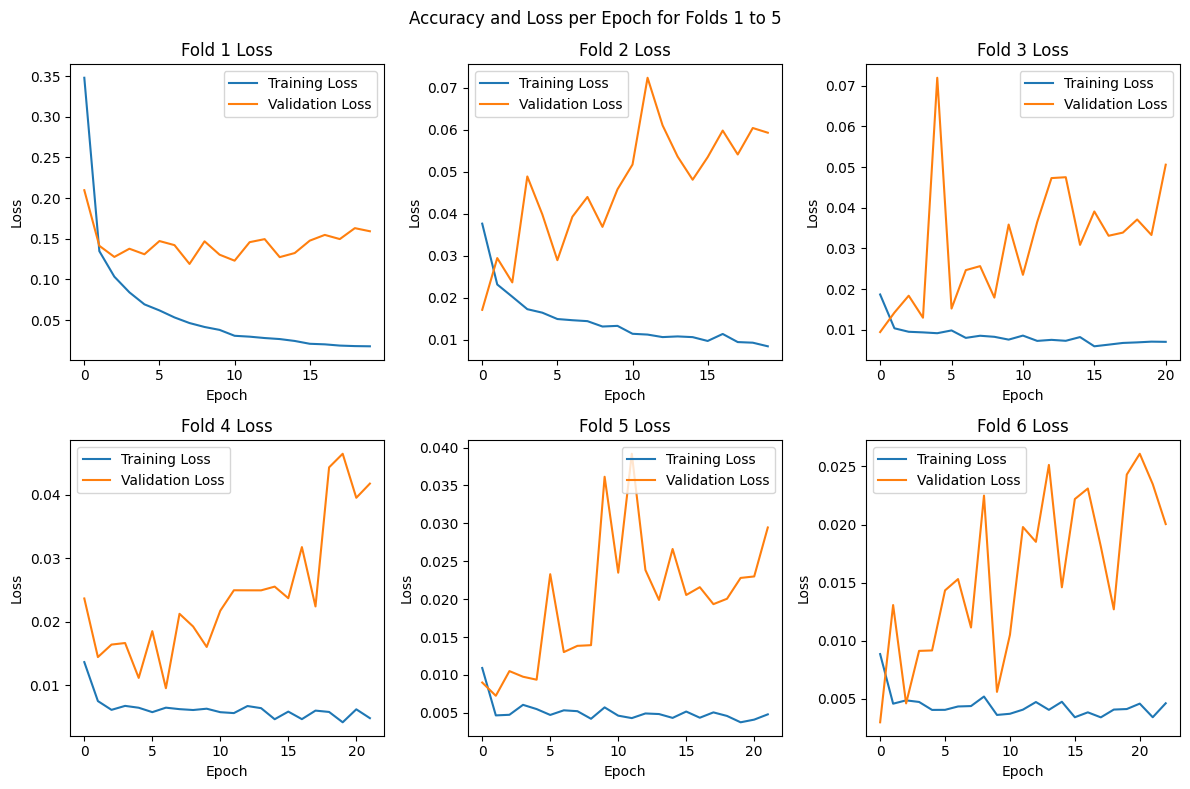

In [26]:
# Determine the number of folds
num_folds = 6  # You can change this to match the actual number of folds

# Create a grid of subplots for each metric (accuracy and loss)
num_rows = 2
num_cols = (num_folds + 1) // 2  # Calculate the number of columns needed based on the number of folds
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.suptitle("Accuracy and Loss per Epoch for Folds 1 to 5")



for fold_number in range(1, num_folds + 1):
    history = foldperf[f"fold{fold_number}"]

    # Calculate the subplot position
    row = (fold_number - 1) // num_cols  # Row number (0 or 1)
    col = (fold_number - 1) % num_cols  # Column number (0 or 1)

    # Plot training and test loss
    axes[row, col].plot(history["train_loss"], label="Training Loss")
    axes[row, col].plot(history["test_loss"], label="Validation Loss")
    axes[row, col].set_xlabel("Epoch")
    axes[row, col].set_ylabel("Loss")
    axes[row, col].set_title(f"Fold {fold_number} Loss")
    axes[row, col].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

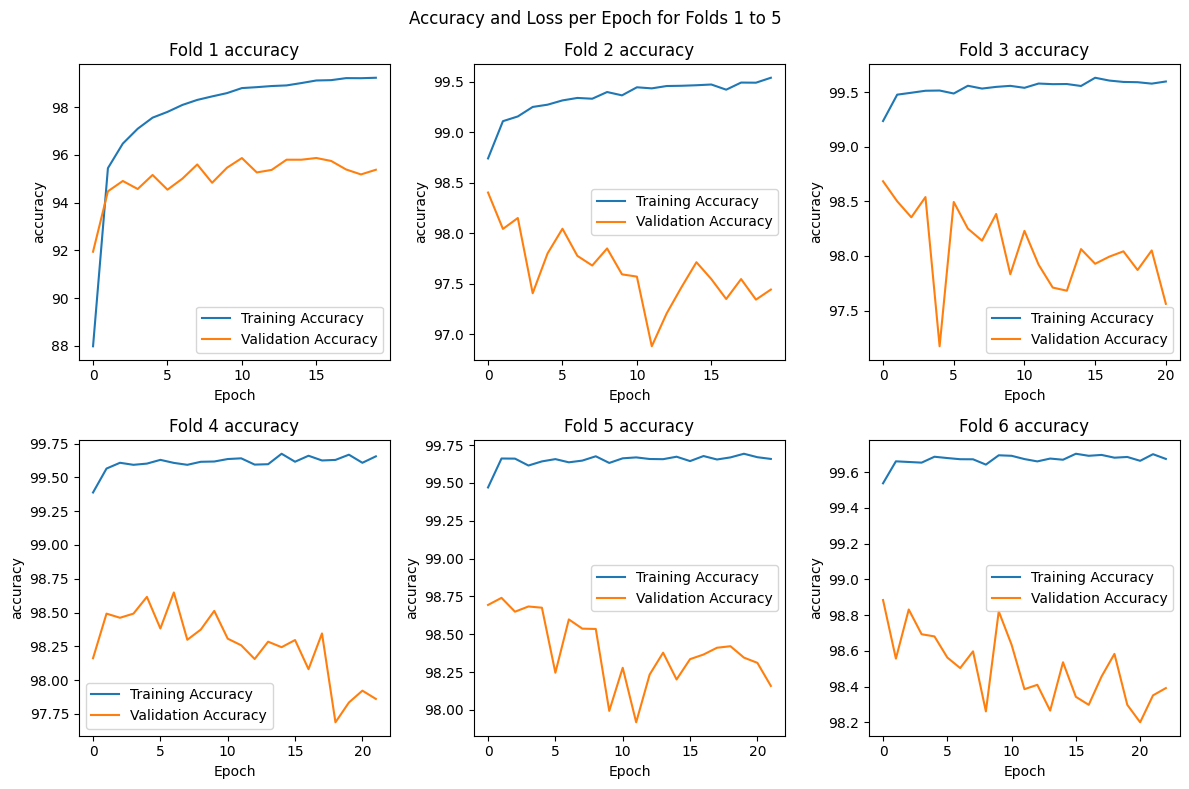

In [27]:
# Determine the number of folds
num_folds = 6  # You can change this to match the actual number of folds

# Create a grid of subplots for each metric (accuracy and loss)
num_rows = 2
num_cols = (num_folds + 1) // 2  # Calculate the number of columns needed based on the number of folds
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.suptitle("Accuracy and Loss per Epoch for Folds 1 to 5")



for fold_number in range(1, num_folds + 1):
    history = foldperf[f"fold{fold_number}"]

    # Calculate the subplot position
    row = (fold_number - 1) // num_cols  # Row number (0 or 1)
    col = (fold_number - 1) % num_cols  # Column number (0 or 1)

    # Plot training and test loss
    axes[row, col].plot(history["train_acc"], label="Training Accuracy")
    axes[row, col].plot(history["test_acc"], label="Validation Accuracy")
    axes[row, col].set_xlabel("Epoch")
    axes[row, col].set_ylabel("accuracy")
    axes[row, col].set_title(f"Fold {fold_number} accuracy")
    axes[row, col].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [28]:
print(history)

{'train_loss': [0.00886108299857154, 0.004592936514387561, 0.004878876692108277, 0.004741748559732661, 0.004057227159226446, 0.004063431895236419, 0.004353157114418268, 0.004387577656168192, 0.005206768645911569, 0.0036244210247075317, 0.0037253263821326764, 0.004079961796430838, 0.004735408088475798, 0.004062171024802514, 0.004757500574610821, 0.0034256795604511374, 0.0038487448509203514, 0.0034167158851681288, 0.0040859902495788926, 0.004132077782451543, 0.004598289995972219, 0.0034271219136768187, 0.004629025590786937], 'test_loss': [0.002991818956681153, 0.013079114172476211, 0.004617018846268183, 0.009135731030653542, 0.009172298577255752, 0.014340669734807616, 0.01531332737675352, 0.01114625687246663, 0.022497377923098603, 0.005610711863935709, 0.010519547854850719, 0.019790373732573936, 0.01851700368413102, 0.025134121819558604, 0.014606869229284633, 0.022198227472558747, 0.023106143762134698, 0.01811756349860188, 0.012709509396814056, 0.024303901276063106, 0.026094720795508643,

In [29]:
torch.save(GoogleNet.state_dict(), 'googlenet_model.pth')

In [10]:
torch.save(train_X, 'train_X.pt')
torch.save(train_Y, 'train_Y.pt')

In [11]:
torch.save(val_X, 'val_X.pt')
torch.save(val_Y, 'val_Y.pt')

In [12]:
torch.save(test_X, 'test_X.pt')
torch.save(test_Y, 'test_Y.pt')